In [67]:
import os
import pandas as pd
import numpy as np
from shutil import rmtree, copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

# Project variables

In [2]:
m_name = "distilbert_2_classes_v2"
p_dir = os.path.join("../nlp models", m_name)

In [3]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [4]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [5]:
create_dir(p_dir)
clear_dir(p_dir)

# Read and transform scraped dataframes

In [6]:
fp = "../scraped data"

channels = pd.read_pickle(os.path.join(fp, "channels.pkl"))
videos = pd.read_pickle(os.path.join(fp, "videos.pkl"))

In [7]:
def transform_channels(df: pd.DataFrame) -> pd.DataFrame:
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type into int64
    fields = ["video_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["subscriber_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    # Add of channel in months
    df["age_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
        
    # Drop unnecessary fields
    df.drop(columns=["custom_url", "country"] + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    # Remove channels without subscriber_count
    df = df.loc[df.subscriber_count.notnull(), :]
    
    return df

In [8]:
def transform_videos(df: pd.DataFrame) -> pd.DataFrame:    
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type to bool
    fields = ["broadcast"]
    df.loc[:, fields] = df.loc[:, fields].astype("bool")
    
    # Convert field type into int64
    fields = ["category_id"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["comment_count", "dislike_count", "like_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    df["published_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
    df["title_len"] = df.title.str.len()
    
    df.drop(columns=["favorite_count", "broadcast", "audio_language", "comment_count", "category_id"] \
            + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    df = df.loc[df.like_count.notnull() & df.dislike_count.notnull() & df.view_count.notnull(), :]
    
    return df

In [9]:
channels_trans = transform_channels(channels)
videos_trans = transform_videos(videos)
combo = videos_trans.merge(channels_trans[["id", "view_count","published", "age_mth", "subscriber_count",
                                             "video_count"]], 
                           how="inner", left_on="channel_id", right_on="id", suffixes=["_video", "_channel"])
combo["ln_vc_norm"] = np.log(combo.video_count / combo.subscriber_count)

# Define categories

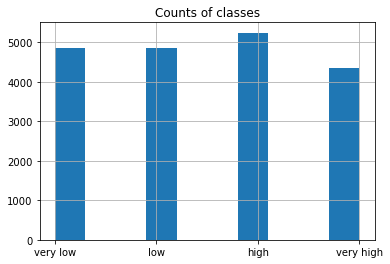

In [10]:
cat_lbl = ["very low", "low", "high", "very high"]
combo.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl), labels=cat_lbl, precision=6)
combo.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

# Split dataset (use only top and bottom quartile data)

In [11]:
cat_lbl = ["very low", "very high"]
combo = combo.loc[combo.qtl.isin(cat_lbl)]
combo.qtl = combo.qtl.cat.remove_unused_categories()

y = combo.qtl
x = combo.loc[:, [c for c in combo.columns if c != "qtl"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

5526 1842 1843


# Build the model

In [12]:
def preprocessing(df: pd.DataFrame, remove_stopwords: bool=False) -> pd.DataFrame:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(row, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(row[field])
        row[field] = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            row[field] = " ".join([w for w in row[field].split() if w not in stw])
        
        return row
    
    df = df.apply(lambda row: cleanse_row(row, field, stw, remove_stopwords), axis=1)
    return df["title"]

In [13]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
remove_stopwords = False

def preprocess_data(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [28]:
x_train_pp = preprocess_data(x_train)
x_test_pp = preprocess_data(x_test)

In [36]:
pt_model = "distilbert-base-uncased"
tok = DistilBertTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [75]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                       return_token_type_ids=True)
        input_ids.append(inputs["input_ids"])
        input_masks.append(inputs["attention_mask"])
        input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

In [84]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states=False
transformer_model = TFDistilBertModel.from_pretrained(pt_model, config=config)

in_ids = Input(shape=(100,), name="input_token", dtype="int32")
in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

emb = transformer_model(in_ids, attention_mask=in_masks)[0]
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(emb)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)
model = Model(inputs=[in_ids, in_masks], outputs=x)

for layer in model.layers[:3]:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [85]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_11 (TFDist TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 100, 100)     327600      tf_distil_bert_model_11[0][

In [ ]:
x_train_tok = tokenize(x_train_pp, tok)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

batch_size = 64
n_epochs = 20

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.0005), 
              metrics=["accuracy"])

metric = "val_accuracy"

es = EarlyStopping(monitor=metric, 
                   mode="max", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='max')

hist = model.fit(x_train_tok[:2], y_train_b, 
                 validation_data=(x_test_tok[:2], y_test_b), 
                 batch_size=batch_size, 
                 epochs=n_epochs, 
                 callbacks=[checkpoint, es])

Epoch 1/20
87/87 [==============================] - 88s 913ms/step - loss: 0.0541 - accuracy: 0.9826 - val_loss: 0.1082 - val_accuracy: 0.9658

Epoch 00001: val_accuracy improved from -inf to 0.96582, saving model to ../nlp models/distilbert_2_classes_v2/distilbert_2_classes_v2
Epoch 2/20
38/87 [============>.................] - ETA: 39s - loss: 0.0330 - accuracy: 0.9897

In [ ]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
# axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))